# Purpose

Attempt to perform an Decision Tree classifier on the cves/metasploit dataset

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from io import StringIO

from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, fbeta_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz

from sklearn.metrics import fbeta_score, make_scorer

from IPython.display import Image  

import pydotplus


%matplotlib inline


In [3]:
CVES_METASPLOIT_ENCODED = '../../data/processed/cves_metasplot_encoded.json'

In [39]:
cves_df = pd.read_json(CVES_METASPLOIT_ENCODED)
cves_df.head()

,access_ADJACENT,access_LOCAL,access_NETWORK,auth_HIGH,auth_LOW,auth_NONE,avail_HIGH,avail_LOW,avail_NONE,comp_HIGH,comp_LOW,conf_HIGH,conf_LOW,conf_NONE,id,integ_HIGH,integ_LOW,integ_NONE,metasploit
0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,CVE-1999-0001,0,0,1,0
1,0,0,1,0,0,1,1,0,0,0,1,1,0,0,CVE-1999-0002,1,0,0,0
2,0,0,1,0,0,1,1,0,0,0,1,1,0,0,CVE-1999-0003,1,0,0,0
3,0,0,1,0,0,1,0,1,0,0,1,0,0,1,CVE-1999-0004,0,0,1,0
4,0,0,1,0,0,1,1,0,0,0,1,1,0,0,CVE-1999-0005,1,0,0,0


In [40]:
X = cves_df.drop(['metasploit', 'id'], axis=1)
y = cves_df['metasploit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [7]:
y_train.mean()

0.016008289081725167

In [8]:
y_test.mean()

0.015852663480592142

Fighting an imbalance problem here, going to keep above for notes and keep experimenting below

In [17]:
param_grid = {"criterion" : ["gini", "entropy"],
              "splitter" :   ["best", "random"],
              "max_depth": [5,6,7,8,9,10, 20, 40, 80, 100],
              "min_samples_split": [2, 4, 8, 16, 24, 48],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6],
              "max_features": [1, 2, 3, 4, 5, 6, 7],
              
             }

model = DecisionTreeClassifier(
    random_state = 11, 
    max_features = "auto", 
    class_weight = "balanced"
)

# run grid search
f10_scorer = make_scorer(fbeta_score, beta=10)

grid_search_model = GridSearchCV(model, param_grid=param_grid, scoring=f10_scorer, cv=5, n_jobs=-1)

grid_search_model.fit(X_train, y_train)
print(grid_search_model)
print(grid_search_model.best_score_)
print(grid_search_model.best_params_)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [5, 6, 7, 8, 9, 10, 20, 40, 80, 100], 'min_samples_split': [2, 4, 8, 16, 24, 48], 'min_samples_leaf': [1, 2, 3, 4, 5, 6], 'max_features': [1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=10), verbose=0)
0.6203615094269612
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 16, 'splitter': 'best'}


In [47]:
model = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=7, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

display(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print("Training Accuracy:", model.score(X_train, y_train))
print("Test Accuracy    :", model.score(X_test, y_test))
print("F10 Score        :", fbeta_score(y_test, y_pred, 10))
print()
print(classification_report(y_test, y_pred))

Predicted,0,1,All
True,,,
0,14712,11088,25800
1,93,339,432
All,14805,11427,26232


Training Accuracy: 0.5804836516589785
Test Accuracy    : 0.5737648673376029
F10 Score        : 0.6267779669394256

             precision    recall  f1-score   support

          0       0.99      0.57      0.72     25800
          1       0.03      0.78      0.06       432

avg / total       0.98      0.57      0.71     26232



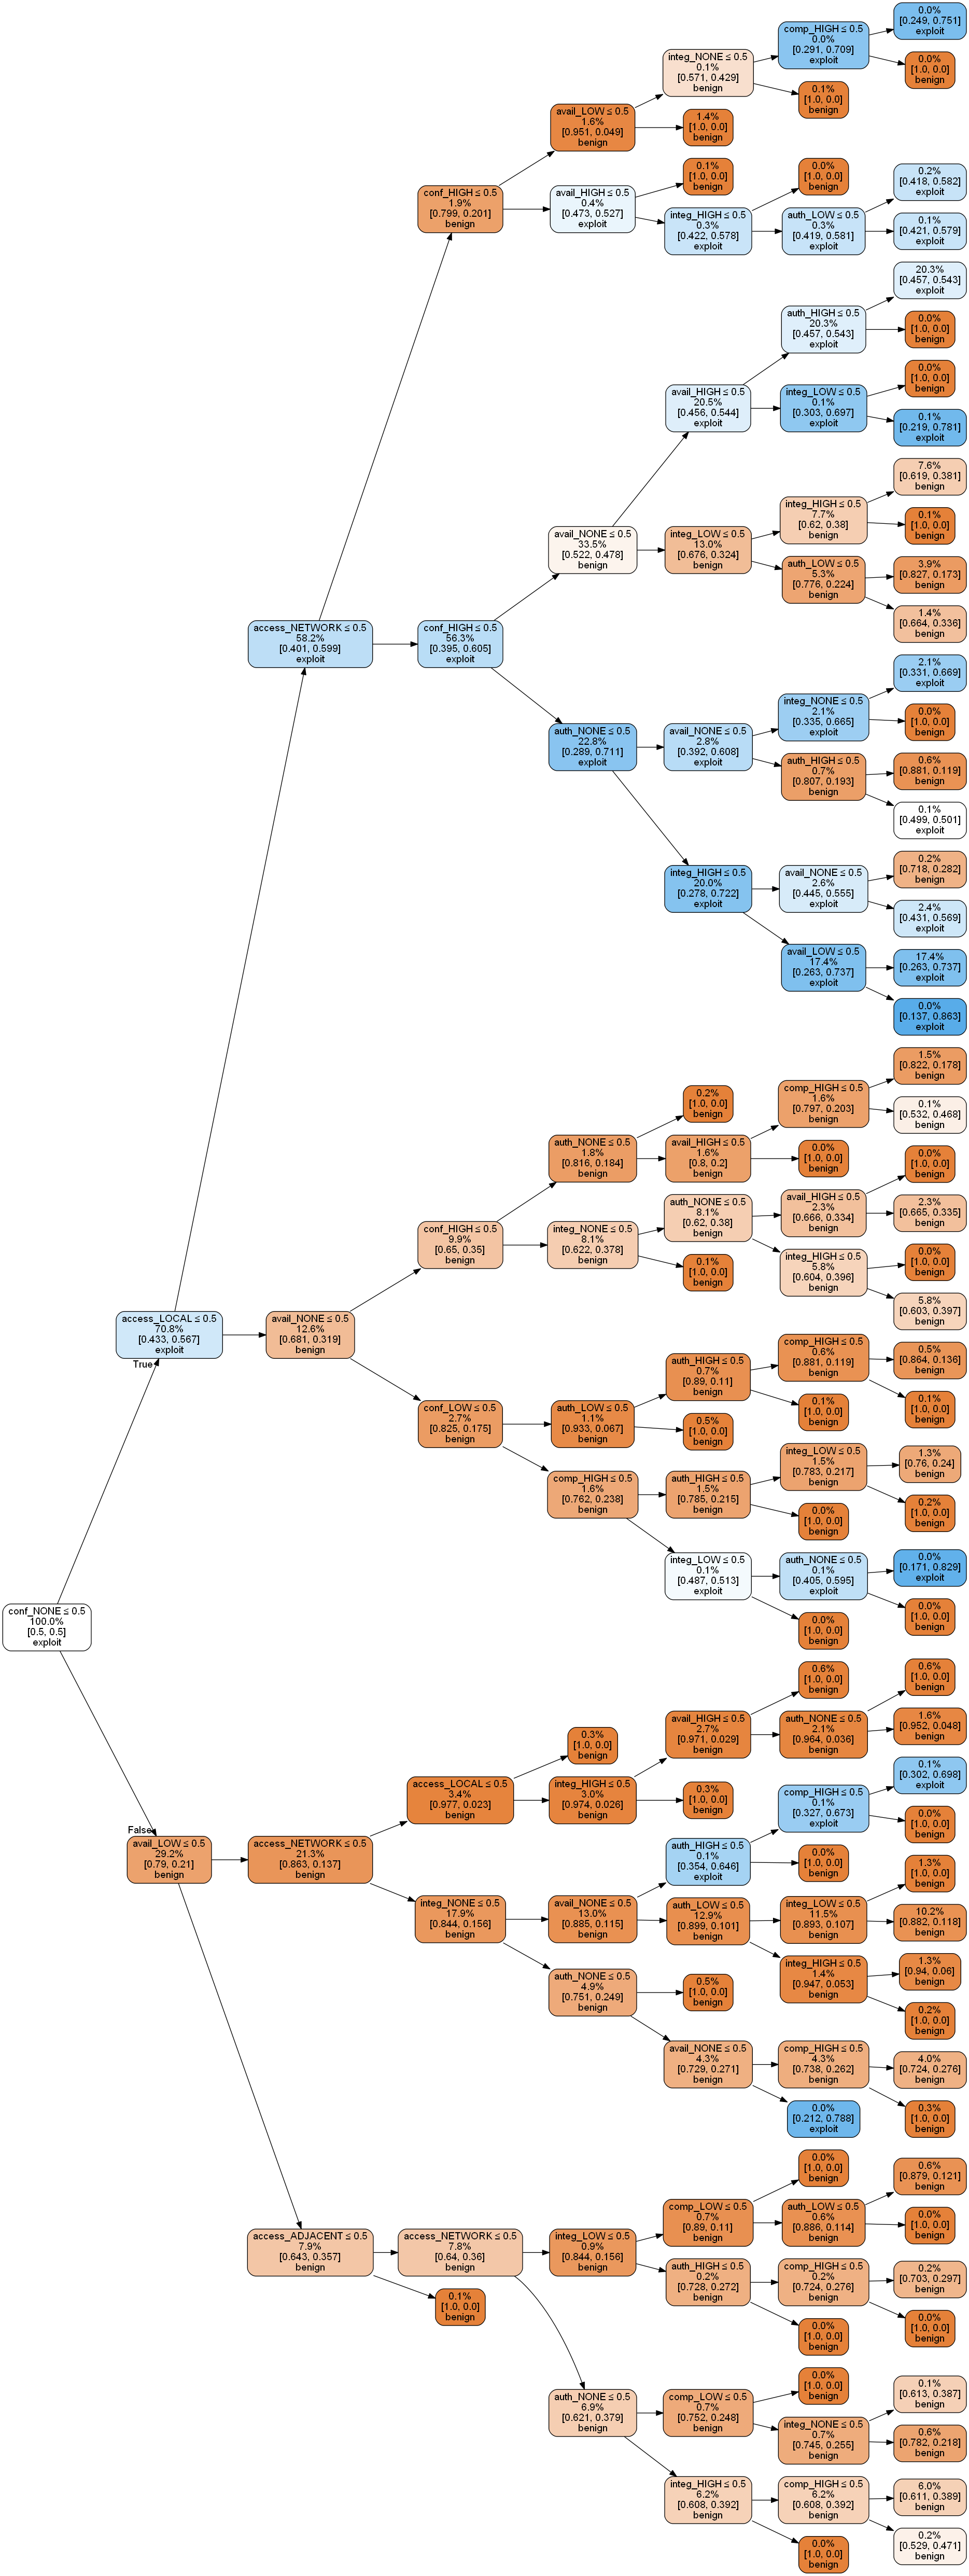

In [46]:
dot_data = StringIO()

export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,proportion=True,
                special_characters=True,
                class_names=['benign', 'exploit'],
                feature_names = X_train.columns,
                rotate=True,
                label='none',
                impurity=False
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png("../../docs/img/dt.png")
Image(graph.create_png())


In [20]:
X_train.columns[9]

'avail_NONE'